# Word Embedding

https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

Learning a word embedding while training a neural network is a common technique to deal with texts in Deep Learning.
Each of the pre-trained word embedding and new (not-trained) embedding and both word embeddings together are used to show the effectiveness of use of pre-trained word embedding.

## Pre-trained word embedding
In this project, we use the GloVe embeddings, which you can read about [here](https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". 
Glove is an unsupervised learning algorithm for obtaining vector representations for words.
It is a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics.

Specifically, we use the 200-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. You can download these data [here](http://nlp.stanford.edu/data/glove.6B.zip).

In addition, to check whether the pre-trained word embedding needs to be trained or not, we made the function below configurable for *trainable* parameter of Embedding object.
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [8]:
EMBEDDING_DIM = 200
def load_pre_trained_embedding(word_index, max_word_length, trainable_for_embedding):
    embeddings_index = {}
    with open('./glove/glove.6B.200d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=max_word_length, weights=[embedding_matrix], trainable=trainable_for_embedding)

## New (not-trained) word embedding
New word embedding is created with no pre-trained weights, and it should be trainable always.

In [9]:
def new_embedding(word_index, max_word_length, trainable_for_embedding):
    # This is new embedding layer, so trainable must be True regardless the value of trainable_for_embedding
    return Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=max_word_length, trainable=True)

# Building a Deep Learning Model

To build a deep learning model, we basically use the sequential model of Keras.

First, the Embedding layer is located. There are two options of setting embedding layers: using the pre-trained word embedding or training new embedding from scratch.

Second, a series of **convolution 1D** and **pooling layers** are added according to typical CNN for text analysis. 

In order to check the effects of the number of convolution layers, we made the function below configurable to set the number of additional convolution layers.

Then, after flattening layer, fully connected dense layers are added.
Since this is a binary classification problem, we use the sigmoid function as an activation function for the final dense layer. If you try to predict a score of a review, it would be better to use 'softmax' function as the activation function.

  - **Activation Function**  
  The activation function is used as a decision making body at the output of a neuron. The neuron learns Linear or Non-linear decision boundaries based on the activation function.

  It also has a normalizing effect on the neuron output which prevents the output of neurons after several layers to become very large, due to the cascading effect.  
  
  There are three most widely used activation functions:
      - **Sigmoid**: It maps the input (x axis) to values between 0 and 1 (which may later results in the [vanishing gradient problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484).
      - **Tanh**: It is similar to the sigmoid function but maps the input to values between -1 and 1.
      - **Rectified Linear Unit (ReLU)**: - It allows only positive values to pass through it. The negative values are mapped to zero.
  - **Dropout**  
  During training, when dropout is applied to a layer, some percentage of its neurons (a hyperparameter, with common values being between 20 and 50%) are randomly deactivated or “dropped out,” along with their connections. Which neurons are dropped out are constantly shuffled randomly during training. This forces the network to learn a more balanced representation, and **helps with overfitting**.

In [10]:
def build_model(word_index, max_word_length, number_of_additional_conv_layers, 
                use_pre_trained_embedding, trainable_for_embedding, number_of_filters, use_dropout, num_units):
    # define model
    model = Sequential()
    embedding_func = new_embedding
    if use_pre_trained_embedding: 
        embedding_func = load_pre_trained_embedding
    model.add(embedding_func(word_index, max_word_length, trainable_for_embedding))
    if use_dropout:
        model.add(Dropout(0.5))
    
    for i in range(number_of_additional_conv_layers):
        model.add(Conv1D(filters=number_of_filters, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        if use_dropout:
            model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=number_of_filters, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=10))
    if use_dropout:
        model.add(Dropout(0.5))

    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(units=num_units, activation='relu')) #num_units= [128,32]
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training Deep Learning Models using Various Parameters

## Various Parameters

Now, all the functions defined above are integrated into the function *build_and_train_model* as below.
We compare the different models by changing the six parameters.
Each model is trained by different combinations of six parameters.

The meanings of parameters can be explained as follows:
* **use_cleaned_docs**: Cleaning review documents or not. 
* **number_of_additional_conv_layers**: Number of additional convolution layers. Basically, one convolution layer is used (`number_of_additional_conv_layers`=0). If you want to add more convolution layers, we can adjust this parameter to a higher number. For experiment, we adjust the `number_of_additional_conv_layers`=2, so the total convolution layers becomes 3.
* **use_pre_trained_embedding**: Using pre-trained embedding or not. If True, the GloVe embedding will be used as mentioned above.
* **trainable_for_embedding**: Training the embedding layer with training data set or freezing. Note, when using the new embedding layer, then trainable_for_embedding should be True. 
* **number_of_filters**: Number of filters in the convolution layers (96 or 24).
* **use_dropout**: Using Dropout or not. In the experiment, 50% percentage of its neurons are randomly deactivated.
* **num_units**: Number of units in Dense layer. This reduces the capacity of network (128 or 32). 

When setting up model configurations by combination of features, there are no cases of no embedding layers 
(`use_pre_trained_embedding`= **False** and `trainable_for_embedding` = **False**), so these should be eliminated.

We use the callbacks functions of `EarlyStopping` and `ModelCheckpoint`.

One way to avoid overfitting is to terminate the process early.
We used the `EarlyStopping` function and set the arguments `monitor`= val_acc (test accuracy) and `patience`=2.
The `patience` indicates the number of epochs with no improvement after which training will be stopped.

The `ModelCheckpoint` callback saves the model after every epoch. 

In [11]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"
modelpath = "./model/{epoch:02d}-{val_acc:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_acc', verbose=0, save_best_only=True)
#early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=2)
early_stopping_callback = EarlyStopping(monitor='val_acc', mode='max', patience=2)

In [12]:
import gc
def build_and_train_model(use_cleaned_docs=False, 
                          number_of_additional_conv_layers=2, 
                          use_pre_trained_embedding=True,
                          trainable_for_embedding=True,
                          number_of_filters=96, 
                          use_dropout=True,
                          num_units=128):
    
    train_positive_docs = global_train_positive_docs
    train_negative_docs = global_train_negative_docs
    test_positive_docs = global_test_positive_docs
    test_negative_docs = global_test_negative_docs
    
    # clean up documents if required
    if use_cleaned_docs:
        train_positive_docs = cleaned_train_positive_docs
        train_negative_docs = cleaned_train_negative_docs
        test_positive_docs = cleaned_test_positive_docs
        test_negative_docs = cleaned_test_negative_docs
    
    # create the tokenizer
    tokenizer = Tokenizer()
    train_docs = train_positive_docs + train_negative_docs
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    #
    print('Fitted tokenizer on {} documents'.format(tokenizer.document_count))
    #print('{} words in dictionary'.format(tokenizer.num_words))
    print('Top 5 most common words are:', Counter(tokenizer.word_counts).most_common(5))
    
    # calculate maximum length of words in training docs
    max_word_length = max([len(s.split()) for s in train_docs])
    # get word_index
    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))

    # encode data into two sequences: x = input, y = output
    x_train, y_train = encode_data_set(tokenizer, train_positive_docs, train_negative_docs, max_word_length)
    x_test, y_test = encode_data_set(tokenizer, test_positive_docs, test_negative_docs, max_word_length)

    # build a model
    model = build_model(word_index, max_word_length, number_of_additional_conv_layers, 
                        use_pre_trained_embedding, trainable_for_embedding, number_of_filters, use_dropout, num_units)
    # fit network (Training)
    history = model.fit(x_train, y_train, epochs=16, verbose=2, validation_data=(x_test, y_test), batch_size=96, callbacks=[TQDMNotebookCallback(), early_stopping_callback, checkpointer])
    # evaluate
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test Accuracy: %.2f%%' % (acc*100))
    
    K.clear_session()
    gc.collect()
    del model
    
    return history

We first start with the following configurations of hyperparameters.

In [13]:
exp_conditions = []

# for use_cleaned_docs in [False]:
#     for number_of_additional_conv_layers in [2]: #[2, 0]
#         for use_pre_trained_embedding in [True, False]:
#             for trainable_for_embedding in [True, False]:
#                 if (not use_pre_trained_embedding) and (not trainable_for_embedding):
#                     continue
#                 for number_of_filters in [96]: #[96, 24]
#                     for use_dropout in [False]: #[True, False]
#                         exp_conditions.append({
#                             'use_cleaned_docs': use_cleaned_docs, 
#                             'number_of_additional_conv_layers': number_of_additional_conv_layers,
#                             'use_pre_trained_embedding': use_pre_trained_embedding,
#                             'trainable_for_embedding': trainable_for_embedding,
#                             'number_of_filters': number_of_filters,
#                             'use_dropout': use_dropout,
#                             'num_units' : 128
#                         })
     

# for use_pre_trained_embedding in [True, False]:
#     for trainable_for_embedding in [True, False]:
#         if (not use_pre_trained_embedding) and (not trainable_for_embedding):
#             continue
#         exp_conditions.append({
#             'use_cleaned_docs': False, 
#             'number_of_additional_conv_layers': 2,
#             'use_pre_trained_embedding': use_pre_trained_embedding,
#             'trainable_for_embedding': trainable_for_embedding,
#             'number_of_filters': 96,
#             'use_dropout': False,
#             'num_units' : 128
#         })

exp_conditions.append({
        'use_cleaned_docs': False, 
        'number_of_additional_conv_layers': 0,
        'use_pre_trained_embedding': True,
        'trainable_for_embedding': False,
        'number_of_filters': 96,
        'use_dropout': False,
        'num_units' : 128
})

exp_conditions.append({
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 0,
    'use_pre_trained_embedding': False,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units' : 128
})
    
exp_conditions.append({
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 0,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units' : 128
})
    
exp_conditions.append({
        'use_cleaned_docs': False, 
        'number_of_additional_conv_layers': 2,
        'use_pre_trained_embedding': True,
        'trainable_for_embedding': False,
        'number_of_filters': 96,
        'use_dropout': False,
        'num_units' : 128
})

exp_conditions.append({
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': False,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units' : 128
})
    
exp_conditions.append({
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units' : 128
})

columns_display = ['use_cleaned_docs','number_of_additional_conv_layers', 'use_pre_trained_embedding', 'trainable_for_embedding', 'number_of_filters', 'use_dropout', 'num_units']
exp_cond_df = pd.DataFrame(exp_conditions, columns=columns_display)
exp_cond_df

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
0,False,0,True,False,96,False,128
1,False,0,False,True,96,False,128
2,False,0,True,True,96,False,128
3,False,2,True,False,96,False,128
4,False,2,False,True,96,False,128
5,False,2,True,True,96,False,128


We build and train models.

In [14]:
exp_result = []

for i, exp_cond in enumerate(exp_conditions):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)
    display(exp_cond_df[i:i+1])
    history = build_and_train_model(**exp_cond)
    print(history)
    exp_result.append(history)

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
0,False,0,True,False,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3022976   
_______________________________________________________

Epoch 1/16


 - 13s - loss: 0.5621 - acc: 0.6917 - val_loss: 0.3647 - val_acc: 0.8443
Epoch 2/16


 - 11s - loss: 0.3300 - acc: 0.8592 - val_loss: 0.3436 - val_acc: 0.8495
Epoch 3/16


 - 11s - loss: 0.2450 - acc: 0.9034 - val_loss: 0.3175 - val_acc: 0.8662
Epoch 4/16


 - 11s - loss: 0.1575 - acc: 0.9444 - val_loss: 0.3778 - val_acc: 0.8542
Epoch 5/16


 - 11s - loss: 0.0779 - acc: 0.9773 - val_loss: 0.4060 - val_acc: 0.8568

Test Accuracy: 85.68%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
1,False,0,False,True,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3022976   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129   

Epoch 1/16


 - 17s - loss: 0.4278 - acc: 0.7754 - val_loss: 0.3067 - val_acc: 0.8717
Epoch 2/16


 - 16s - loss: 0.1409 - acc: 0.9494 - val_loss: 0.3175 - val_acc: 0.8750
Epoch 3/16


 - 16s - loss: 0.0379 - acc: 0.9888 - val_loss: 0.4210 - val_acc: 0.8685
Epoch 4/16


 - 16s - loss: 0.0094 - acc: 0.9980 - val_loss: 0.6024 - val_acc: 0.8602

Test Accuracy: 86.02%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
2,False,0,True,True,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3022976   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129   

Epoch 1/16


 - 17s - loss: 0.4983 - acc: 0.7295 - val_loss: 0.2875 - val_acc: 0.8793
Epoch 2/16


 - 16s - loss: 0.2064 - acc: 0.9205 - val_loss: 0.2992 - val_acc: 0.8804
Epoch 3/16


 - 16s - loss: 0.0824 - acc: 0.9739 - val_loss: 0.3089 - val_acc: 0.8882
Epoch 4/16


 - 16s - loss: 0.0206 - acc: 0.9951 - val_loss: 0.4356 - val_acc: 0.8806
Epoch 5/16


 - 16s - loss: 0.0068 - acc: 0.9988 - val_loss: 0.4831 - val_acc: 0.8816

Test Accuracy: 88.16%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
3,False,2,True,False,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 14s - loss: 0.4720 - acc: 0.7565 - val_loss: 0.3248 - val_acc: 0.8603
Epoch 2/16


 - 14s - loss: 0.2968 - acc: 0.8766 - val_loss: 0.2846 - val_acc: 0.8797
Epoch 3/16


 - 14s - loss: 0.2307 - acc: 0.9092 - val_loss: 0.4205 - val_acc: 0.8147
Epoch 4/16


 - 14s - loss: 0.1840 - acc: 0.9286 - val_loss: 0.2772 - val_acc: 0.8863
Epoch 5/16


 - 14s - loss: 0.1208 - acc: 0.9556 - val_loss: 0.3518 - val_acc: 0.8715
Epoch 6/16


 - 14s - loss: 0.0738 - acc: 0.9737 - val_loss: 0.4007 - val_acc: 0.8781

Test Accuracy: 87.81%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
4,False,2,False,True,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.4198 - acc: 0.7726 - val_loss: 0.2655 - val_acc: 0.8911
Epoch 2/16


 - 18s - loss: 0.1374 - acc: 0.9495 - val_loss: 0.3030 - val_acc: 0.8798
Epoch 3/16


 - 18s - loss: 0.0393 - acc: 0.9883 - val_loss: 0.4427 - val_acc: 0.8722

Test Accuracy: 87.22%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units
5,False,2,True,True,96,False,128


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.4342 - acc: 0.7738 - val_loss: 0.2872 - val_acc: 0.8827
Epoch 2/16


 - 18s - loss: 0.2025 - acc: 0.9229 - val_loss: 0.2560 - val_acc: 0.8973
Epoch 3/16


 - 18s - loss: 0.0978 - acc: 0.9672 - val_loss: 0.3387 - val_acc: 0.8798
Epoch 4/16


 - 18s - loss: 0.0307 - acc: 0.9913 - val_loss: 0.4781 - val_acc: 0.8748

Test Accuracy: 87.48%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,False,96,False,128,0.86624


<IPython.core.display.Javascript object>


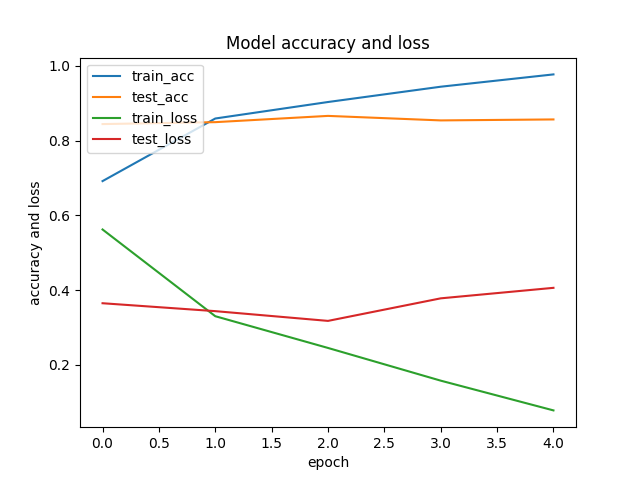

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,False,True,96,False,128,0.875


<IPython.core.display.Javascript object>


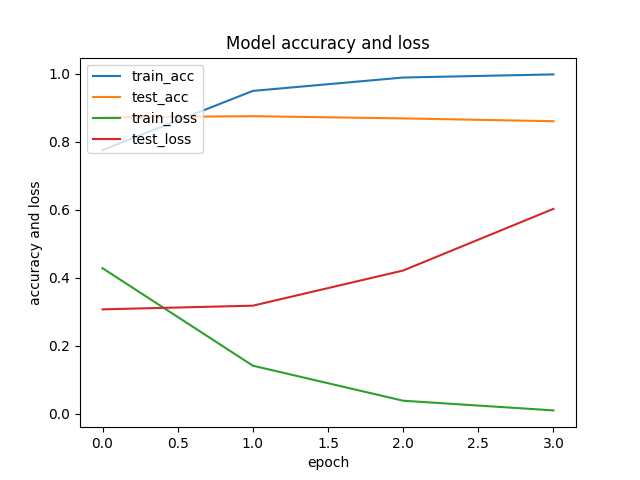

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,True,96,False,128,0.88824


<IPython.core.display.Javascript object>


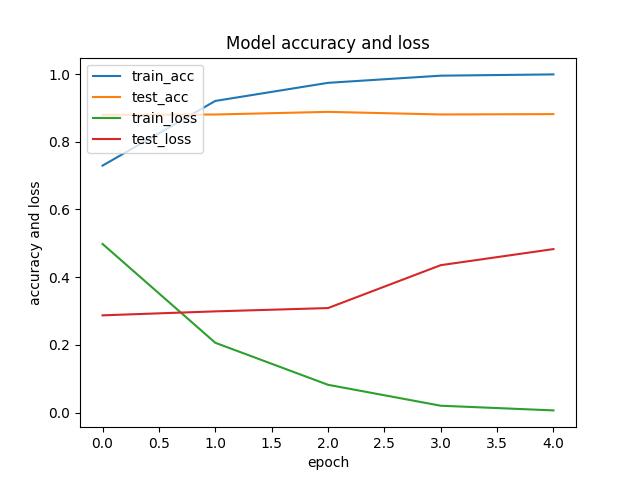

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,False,96,False,128,0.88628


<IPython.core.display.Javascript object>


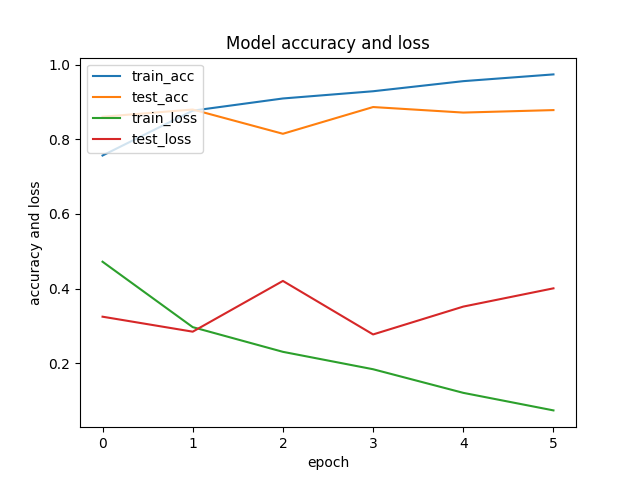

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,False,True,96,False,128,0.89108


<IPython.core.display.Javascript object>


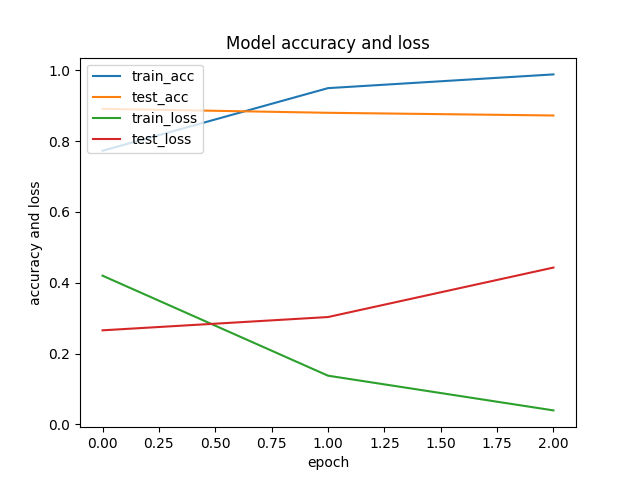

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,False,128,0.89732


<IPython.core.display.Javascript object>


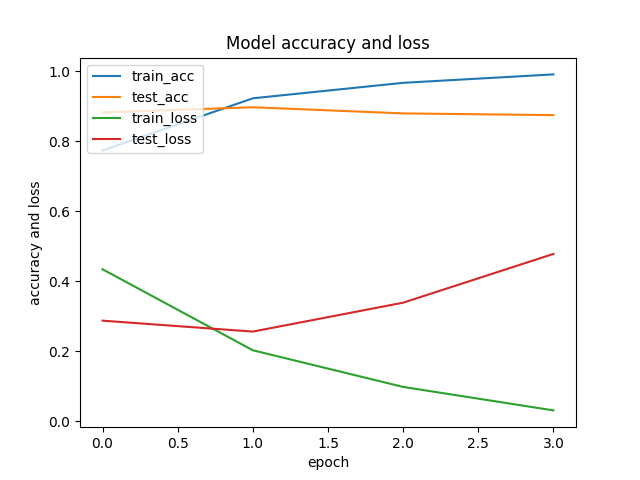

In [15]:
%matplotlib notebook

import matplotlib.pyplot as plt
 
columns_display = ['use_cleaned_docs','number_of_additional_conv_layers', 'use_pre_trained_embedding', 'trainable_for_embedding', 'number_of_filters', 'use_dropout', 'num_units', 'val_acc']


def drawModelAcc_Loss(history, exp_cond):
    exp_cond['val_acc'] = max(history.history['val_acc'])
    #exp_cond['val_acc'] = history.history['val_acc'][-1]
    #exp_cond['num'] = i
    exp_cond_row_df = pd.DataFrame([exp_cond], columns=columns_display)
    #print(history.history['val_acc'])
    display(exp_cond_row_df)
    #display(exp_cond_row_df.to_string(index=False))
    #i = i + 1
    #print(exp_cond)
    
    plt.figure()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model accuracy and loss')
    plt.ylabel('accuracy and loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='upper left')
    plt.show()
    
    
    # Plot training & validation loss values
#     plt.figure()
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

#i = 0
for history, exp_cond in zip(exp_result, exp_conditions):
    #exp_cond['val_acc'] = history.history['val_acc'][-1]
    drawModelAcc_Loss(history, exp_cond)   

In [16]:
exp_cond_df = pd.DataFrame(exp_conditions, columns=columns_display)
exp_cond_df['val_acc'] = exp_cond_df['val_acc'].apply(lambda x:x*100)
exp_cond_df['val_acc'] = exp_cond_df['val_acc'].round(2)

In [17]:
exp_cond_df

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,False,96,False,128,86.62
1,False,0,False,True,96,False,128,87.50
2,False,0,True,True,96,False,128,88.82
3,False,2,True,False,96,False,128,88.63
4,False,2,False,True,96,False,128,89.11
5,False,2,True,True,96,False,128,89.73


### Previous model accuracy

[1] Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

In the paper [1], the performance of machine learning models are in range of 67.42% to 88.89%. The model performed best in the cross validated Support Vector Machine (SVM) when concatenated with bag of words representation.

### Base model

We set the following model as a base model because it produces the best accuracy.

In [18]:
exp_cond_df.iloc[[5]]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
5,False,2,True,True,96,False,128,89.73


# Preventing Overfitting

In [19]:
def draw_build_and_train_model(exp_cond):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)
    history = build_and_train_model(**exp_cond)
    #print(history)
    exp_result.append(history)
    drawModelAcc_Loss(history, exp_cond)
    
    #one dict to Dataframe
    df_exp_cond = pd.DataFrame([exp_cond], columns=columns_display)
    df_exp_cond['val_acc'] = df_exp_cond['val_acc'].apply(lambda x:x*100)
    df_exp_cond['val_acc'] = df_exp_cond['val_acc'].round(2)
    return df_exp_cond

Here the most common ways to prevent overfitting in neural networks:

- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.
- Data-augmentation
- Batch normalization

We apply those techniques to avoid overfitting problem. 

#### number of additional convolutional layers = 0 && network size reduction && dropout 

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 24)          24024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 24)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5904)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                188960    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33    

Epoch 1/16


 - 10s - loss: 0.4686 - acc: 0.7563 - val_loss: 0.3020 - val_acc: 0.8737
Epoch 2/16


 - 9s - loss: 0.2072 - acc: 0.9219 - val_loss: 0.3018 - val_acc: 0.8764
Epoch 3/16


 - 9s - loss: 0.0902 - acc: 0.9706 - val_loss: 0.3330 - val_acc: 0.8798
Epoch 4/16


 - 9s - loss: 0.0233 - acc: 0.9946 - val_loss: 0.3967 - val_acc: 0.8839
Epoch 5/16


 - 9s - loss: 0.0058 - acc: 0.9992 - val_loss: 0.4791 - val_acc: 0.8773
Epoch 6/16


 - 9s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5219 - val_acc: 0.8814

Test Accuracy: 88.14%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,True,24,False,32,0.88388


<IPython.core.display.Javascript object>


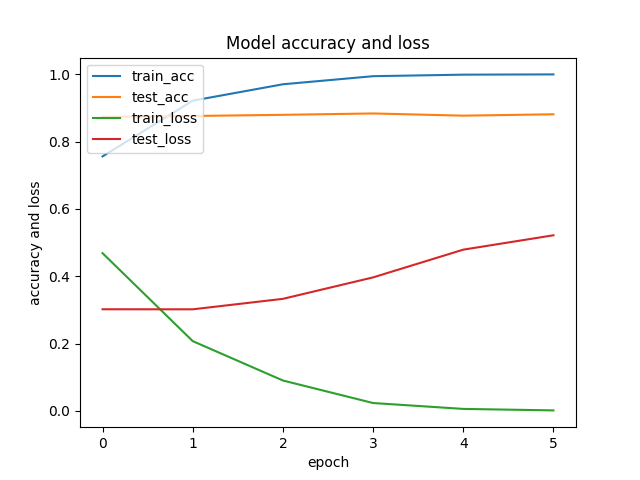

In [20]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 0,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 24,
    'use_dropout': False,
    'num_units': 32
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 24)          24024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 24)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 24)           0         
____________

Epoch 1/16


 - 13s - loss: 0.6723 - acc: 0.5558 - val_loss: 0.4872 - val_acc: 0.8018
Epoch 2/16


 - 13s - loss: 0.3704 - acc: 0.8382 - val_loss: 0.3056 - val_acc: 0.8782
Epoch 3/16


 - 13s - loss: 0.2685 - acc: 0.8917 - val_loss: 0.2700 - val_acc: 0.8907
Epoch 4/16


 - 13s - loss: 0.2167 - acc: 0.9139 - val_loss: 0.2592 - val_acc: 0.8949
Epoch 5/16


 - 13s - loss: 0.1748 - acc: 0.9338 - val_loss: 0.2679 - val_acc: 0.8921
Epoch 6/16


 - 13s - loss: 0.1386 - acc: 0.9472 - val_loss: 0.2770 - val_acc: 0.8903

Test Accuracy: 89.03%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,True,24,True,32,0.89488


<IPython.core.display.Javascript object>


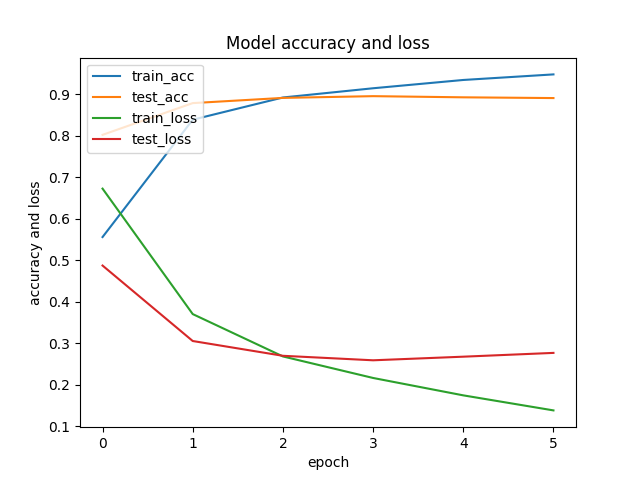

In [21]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 0,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 24,
    'use_dropout': True,
    'num_units': 32
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Reduce the network size 1. 'number_of_filters' : 96 to 48 and 24

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 48)           11568     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 48)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 48)           11568 

Epoch 1/16


 - 14s - loss: 0.4273 - acc: 0.7833 - val_loss: 0.2810 - val_acc: 0.8835
Epoch 2/16


 - 13s - loss: 0.2096 - acc: 0.9190 - val_loss: 0.2558 - val_acc: 0.8962
Epoch 3/16


 - 13s - loss: 0.1027 - acc: 0.9651 - val_loss: 0.2935 - val_acc: 0.8886
Epoch 4/16


 - 13s - loss: 0.0389 - acc: 0.9886 - val_loss: 0.3749 - val_acc: 0.8870

Test Accuracy: 88.70%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,48,False,128,0.8962


<IPython.core.display.Javascript object>


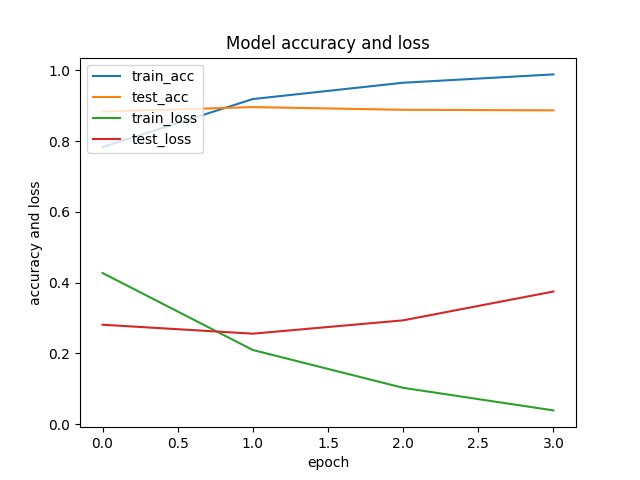

In [22]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 48,
    'use_dropout': False,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 24)          24024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 24)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 24)           2904      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 24)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 24)           2904  

Epoch 1/16


 - 10s - loss: 0.4858 - acc: 0.7335 - val_loss: 0.3505 - val_acc: 0.8455
Epoch 2/16


 - 10s - loss: 0.2251 - acc: 0.9131 - val_loss: 0.2603 - val_acc: 0.8951
Epoch 3/16


 - 10s - loss: 0.1091 - acc: 0.9625 - val_loss: 0.3046 - val_acc: 0.8864
Epoch 4/16


 - 10s - loss: 0.0445 - acc: 0.9864 - val_loss: 0.3974 - val_acc: 0.8851

Test Accuracy: 88.51%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,24,False,128,0.89508


<IPython.core.display.Javascript object>


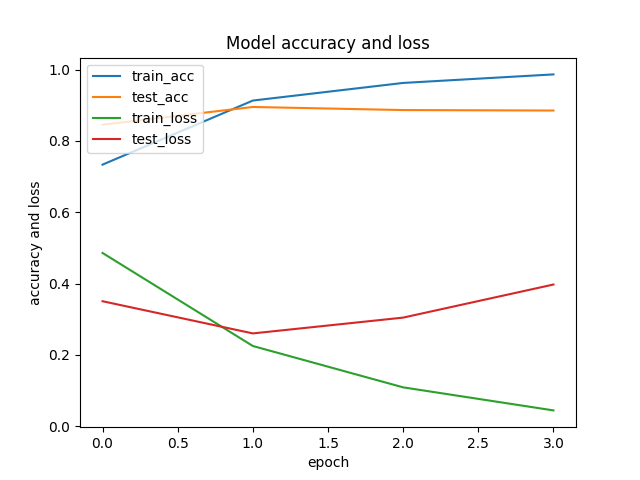

In [23]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 24,
    'use_dropout': False,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Reduce the network size 2-1. 'num_units': 128 to 32

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.4511 - acc: 0.7620 - val_loss: 0.2764 - val_acc: 0.8858
Epoch 2/16


 - 18s - loss: 0.2025 - acc: 0.9223 - val_loss: 0.3194 - val_acc: 0.8702
Epoch 3/16


 - 18s - loss: 0.1062 - acc: 0.9646 - val_loss: 0.2803 - val_acc: 0.8942
Epoch 4/16


 - 18s - loss: 0.0388 - acc: 0.9876 - val_loss: 0.4645 - val_acc: 0.8726
Epoch 5/16


 - 18s - loss: 0.0112 - acc: 0.9973 - val_loss: 0.5555 - val_acc: 0.8858

Test Accuracy: 88.58%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,False,32,0.8942


<IPython.core.display.Javascript object>


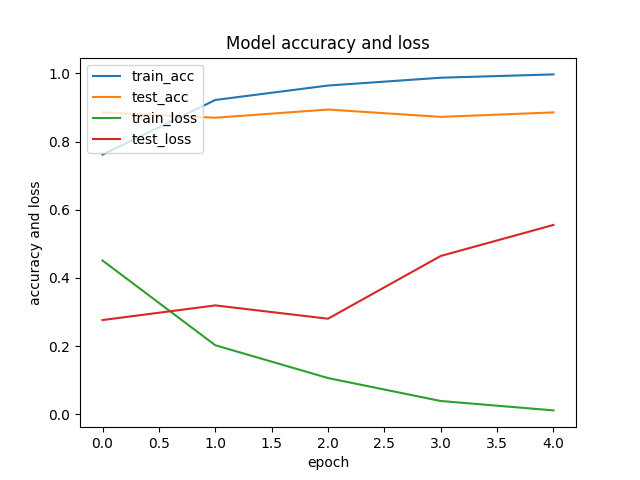

In [24]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units': 32
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Reduce the network size 2-2. 'num_units': 128 to 64

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.4433 - acc: 0.7740 - val_loss: 0.2678 - val_acc: 0.8904
Epoch 2/16


 - 19s - loss: 0.2023 - acc: 0.9223 - val_loss: 0.2468 - val_acc: 0.9014
Epoch 3/16


 - 19s - loss: 0.1006 - acc: 0.9651 - val_loss: 0.3010 - val_acc: 0.8925
Epoch 4/16


 - 19s - loss: 0.0432 - acc: 0.9864 - val_loss: 0.4467 - val_acc: 0.8818

Test Accuracy: 88.18%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,False,64,0.90144


<IPython.core.display.Javascript object>


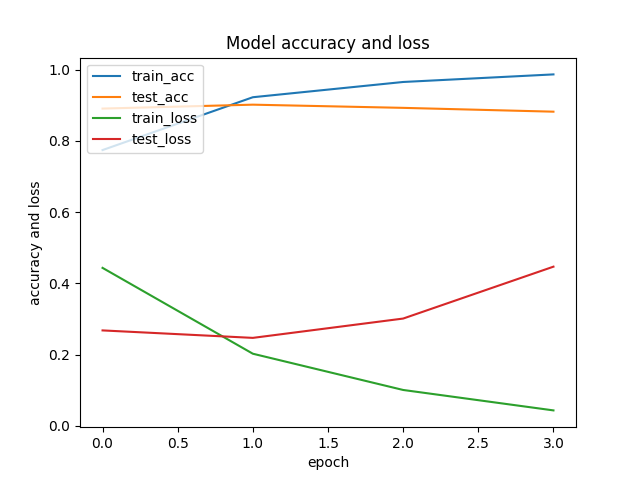

In [25]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units': 64
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Reduce the network size 2-3. 'num_units': 128 to 8

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.5209 - acc: 0.7373 - val_loss: 0.2804 - val_acc: 0.8873
Epoch 2/16


 - 18s - loss: 0.2260 - acc: 0.9102 - val_loss: 0.2666 - val_acc: 0.8904
Epoch 3/16


 - 19s - loss: 0.1191 - acc: 0.9576 - val_loss: 0.2988 - val_acc: 0.8864
Epoch 4/16


 - 18s - loss: 0.0431 - acc: 0.9872 - val_loss: 0.3707 - val_acc: 0.8920
Epoch 5/16


 - 18s - loss: 0.0130 - acc: 0.9962 - val_loss: 0.4763 - val_acc: 0.8885
Epoch 6/16


 - 19s - loss: 0.0054 - acc: 0.9986 - val_loss: 0.9771 - val_acc: 0.8385

Test Accuracy: 83.85%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,False,8,0.89204


<IPython.core.display.Javascript object>


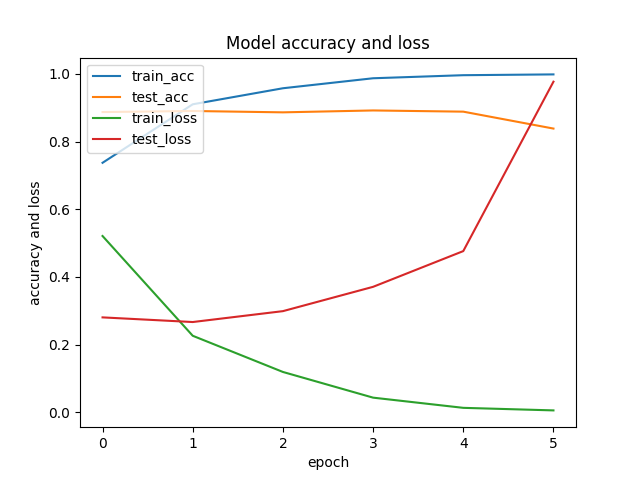

In [26]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units': 8
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Reduce the network size 3. 'number_of_filters' : 96 to 24 and 'num_units': 128 to 32

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 24)          24024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 24)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 24)           2904      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 24)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 24)           2904  

Epoch 1/16


 - 11s - loss: 0.4537 - acc: 0.7746 - val_loss: 0.2942 - val_acc: 0.8773
Epoch 2/16


 - 10s - loss: 0.2152 - acc: 0.9160 - val_loss: 0.3136 - val_acc: 0.8706
Epoch 3/16


 - 10s - loss: 0.1123 - acc: 0.9625 - val_loss: 0.2861 - val_acc: 0.8912
Epoch 4/16


 - 10s - loss: 0.0479 - acc: 0.9866 - val_loss: 0.4253 - val_acc: 0.8747
Epoch 5/16


 - 10s - loss: 0.0183 - acc: 0.9953 - val_loss: 0.4622 - val_acc: 0.8836

Test Accuracy: 88.36%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,24,False,32,0.89124


<IPython.core.display.Javascript object>


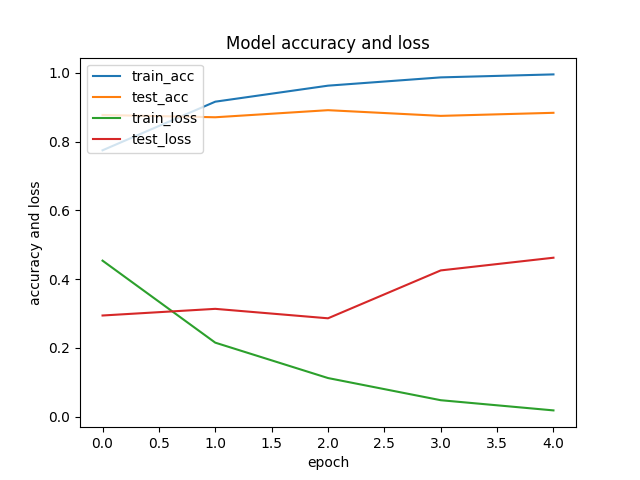

In [27]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 24,
    'use_dropout': False,
    'num_units': 32
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### Dropout

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176 

Epoch 1/16


 - 23s - loss: 0.6630 - acc: 0.5822 - val_loss: 0.4912 - val_acc: 0.7948
Epoch 2/16


 - 22s - loss: 0.3901 - acc: 0.8293 - val_loss: 0.3289 - val_acc: 0.8788
Epoch 3/16


 - 22s - loss: 0.2858 - acc: 0.8833 - val_loss: 0.3077 - val_acc: 0.8917
Epoch 4/16


 - 22s - loss: 0.2300 - acc: 0.9073 - val_loss: 0.2985 - val_acc: 0.8918
Epoch 5/16


 - 22s - loss: 0.1837 - acc: 0.9294 - val_loss: 0.2890 - val_acc: 0.8872
Epoch 6/16


 - 22s - loss: 0.1479 - acc: 0.9445 - val_loss: 0.2709 - val_acc: 0.8909

Test Accuracy: 89.09%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,True,128,0.89176


<IPython.core.display.Javascript object>


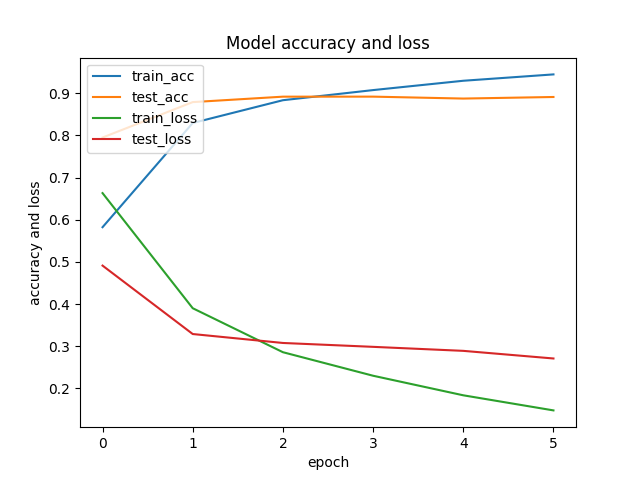

In [28]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': True,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 616, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 48)           11568 

Epoch 1/16


 - 18s - loss: 0.7015 - acc: 0.5086 - val_loss: 0.6929 - val_acc: 0.4994
Epoch 2/16


 - 17s - loss: 0.6254 - acc: 0.6233 - val_loss: 0.4803 - val_acc: 0.8200
Epoch 3/16


 - 17s - loss: 0.3770 - acc: 0.8361 - val_loss: 0.3596 - val_acc: 0.8772
Epoch 4/16


 - 17s - loss: 0.2882 - acc: 0.8819 - val_loss: 0.3340 - val_acc: 0.8867
Epoch 5/16


 - 17s - loss: 0.2396 - acc: 0.9070 - val_loss: 0.3146 - val_acc: 0.8899
Epoch 6/16


 - 17s - loss: 0.1923 - acc: 0.9256 - val_loss: 0.2861 - val_acc: 0.8873
Epoch 7/16


 - 17s - loss: 0.1673 - acc: 0.9366 - val_loss: 0.2989 - val_acc: 0.8824

Test Accuracy: 88.24%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,48,True,128,0.88992


<IPython.core.display.Javascript object>


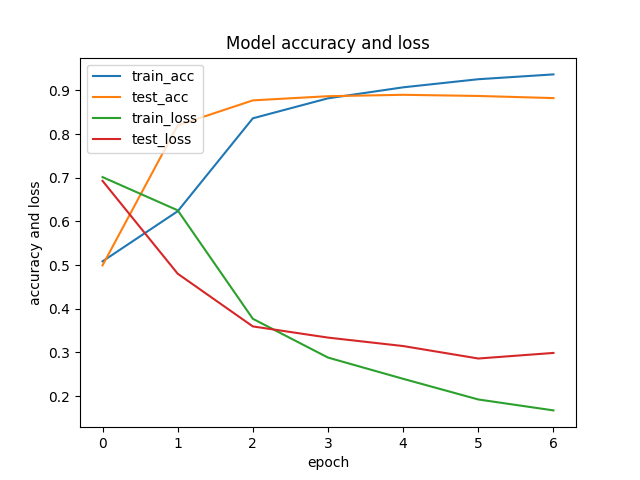

In [29]:
exp_cond = {
    'use_cleaned_docs': False, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 48,
    'use_dropout': True,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

#### use_clean_docs = True

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('br', 101871), ('movi', 50895), ('film', 47472), ('nt', 33378), ('one', 27028)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1425, 200)         6164000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1425, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1421, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 355, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 355, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 351, 96)           46176 

Epoch 1/16


 - 14s - loss: 0.6945 - acc: 0.5246 - val_loss: 0.6412 - val_acc: 0.6809
Epoch 2/16


 - 13s - loss: 0.4820 - acc: 0.7716 - val_loss: 0.3857 - val_acc: 0.8576
Epoch 3/16


 - 13s - loss: 0.3198 - acc: 0.8678 - val_loss: 0.3462 - val_acc: 0.8609
Epoch 4/16


 - 13s - loss: 0.2638 - acc: 0.8944 - val_loss: 0.3304 - val_acc: 0.8689
Epoch 5/16


 - 13s - loss: 0.2211 - acc: 0.9121 - val_loss: 0.3206 - val_acc: 0.8698
Epoch 6/16


 - 13s - loss: 0.1911 - acc: 0.9272 - val_loss: 0.3228 - val_acc: 0.8676
Epoch 7/16


 - 13s - loss: 0.1701 - acc: 0.9342 - val_loss: 0.3322 - val_acc: 0.8580

Test Accuracy: 85.80%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,True,2,True,True,96,True,128,0.8698


<IPython.core.display.Javascript object>


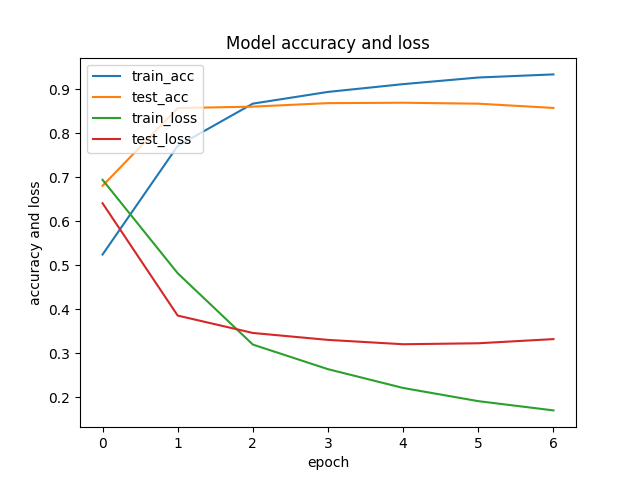

In [30]:
# use_clean_docs = True
exp_cond = {
    'use_cleaned_docs': True, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': True,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('br', 101871), ('movi', 50895), ('film', 47472), ('nt', 33378), ('one', 27028)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1425, 200)         6164000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1421, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 355, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 351, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 87, 96)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 83, 96)            46176 

Epoch 1/16


 - 11s - loss: 0.4448 - acc: 0.7778 - val_loss: 0.3255 - val_acc: 0.8586
Epoch 2/16


 - 11s - loss: 0.2222 - acc: 0.9137 - val_loss: 0.3034 - val_acc: 0.8736
Epoch 3/16


 - 11s - loss: 0.1182 - acc: 0.9588 - val_loss: 0.3508 - val_acc: 0.8676
Epoch 4/16


 - 11s - loss: 0.0523 - acc: 0.9836 - val_loss: 0.5076 - val_acc: 0.8536

Test Accuracy: 85.36%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,True,2,True,True,96,False,128,0.87356


<IPython.core.display.Javascript object>


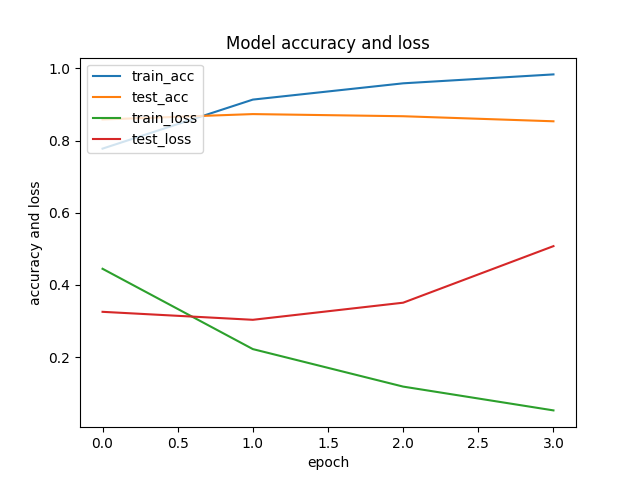

In [31]:
exp_cond = {
    'use_cleaned_docs': True, 
    'number_of_additional_conv_layers': 2,
    'use_pre_trained_embedding': True,
    'trainable_for_embedding': True,
    'number_of_filters': 96,
    'use_dropout': False,
    'num_units': 128
}

df_exp_cond_result = draw_build_and_train_model(exp_cond)
exp_cond_df = exp_cond_df.append(df_exp_cond_result)

Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 616, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 612, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 153, 96)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 96)           46176 

Epoch 1/16


 - 19s - loss: 0.4243 - acc: 0.7884 - val_loss: 0.2743 - val_acc: 0.8877
Epoch 2/16


 - 19s - loss: 0.1995 - acc: 0.9232 - val_loss: 0.2547 - val_acc: 0.8970
Epoch 3/16


 - 19s - loss: 0.1003 - acc: 0.9651 - val_loss: 0.2977 - val_acc: 0.8876
Epoch 4/16


 - 19s - loss: 0.0331 - acc: 0.9901 - val_loss: 0.4381 - val_acc: 0.8864

Test Accuracy: 88.64%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,2,True,True,96,False,128,0.897


<IPython.core.display.Javascript object>


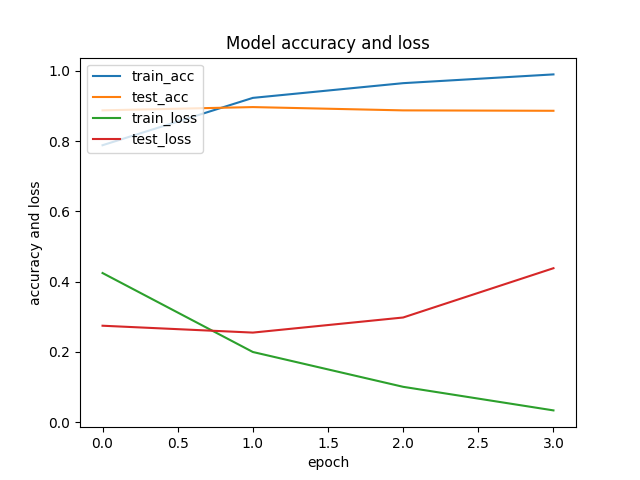

In [32]:
# duplicated configuration - to see producing same result --> no (deep learning has random characteristics)

# exp_cond = {
#     'use_cleaned_docs': False, 
#     'number_of_additional_conv_layers': 2,
#     'use_pre_trained_embedding': True,
#     'trainable_for_embedding': True,
#     'number_of_filters': 96,
#     'use_dropout': False,
#     'num_units': 128
# }

# df_exp_cond_result = draw_build_and_train_model(exp_cond)
# exp_cond_df = exp_cond_df.append(df_exp_cond_result)

### Final results

In [49]:
#final
exp_cond_df2=exp_cond_df.copy()

In [64]:
exp_cond_df = exp_cond_df.reset_index(drop=True)

In [82]:
exp_cond_df = exp_cond_df.drop(columns="dup")

In [85]:
exp_cond_df = exp_cond_df.drop([18], axis=0)

In [86]:
exp_cond_df

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,False,96,False,128,86.62
1,False,0,False,True,96,False,128,87.50
2,False,0,True,True,96,False,128,88.82
3,False,2,True,False,96,False,128,88.63
4,False,2,False,True,96,False,128,89.11
5,False,2,True,True,96,False,128,89.73
6,False,0,True,True,24,False,32,88.39
7,False,0,True,True,24,True,32,89.49
8,False,2,True,True,48,False,128,89.62
9,False,2,True,True,24,False,128,89.51


In [87]:
exp_cond_df.sort_values(by=['val_acc'], ascending=False)

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
11,False,2,True,True,96,False,64,90.14
5,False,2,True,True,96,False,128,89.73
8,False,2,True,True,48,False,128,89.62
9,False,2,True,True,24,False,128,89.51
7,False,0,True,True,24,True,32,89.49
10,False,2,True,True,96,False,32,89.42
12,False,2,True,True,96,False,8,89.20
14,False,2,True,True,96,True,128,89.18
13,False,2,True,True,24,False,32,89.12
4,False,2,False,True,96,False,128,89.11


## Conclusion


1. **Overall accuracy**  
The accuracy is best as 90.14% in the following conditions.

In [89]:
#Base model
exp_cond_df.sort_values(by=['val_acc'], ascending=False).head(1)

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
11,False,2,True,True,96,False,64,90.14


2. **Word embedding**  

For the word embedding, the **use of sole pre-trained word embedding produces the least performance.** This can be interpreted that Embedding model cannot be generalized and should be differentiated (trained) into their contexts. Rather, **the use of the new training word embedding was the better choice.** 

Most of all, **models that use the pre-trained word embedding and updating weights during training provide the best performance.** Using the pre-trained word embedding produces the better performance takes advantages of leveraging massive datasets with a vast corpus of language capturing word meanings in a statistically robust manner. 
It is difficult to train from scratch, therefore, we need to use the pre-defined word embedding and customize it into our dataset at the same time.

In [91]:
#number_of_additional_conv_layers = 0 
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['number_of_additional_conv_layers']==0) & 
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,False,96,False,128,86.62
1,False,0,False,True,96,False,128,87.50
2,False,0,True,True,96,False,128,88.82


In [92]:
#number_of_additional_conv_layers = 2
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
3,False,2,True,False,96,False,128,88.63
4,False,2,False,True,96,False,128,89.11
5,False,2,True,True,96,False,128,89.73


3-1. **Network size: Nubmer of convolutional neural network layers (0, 2)**  
The model with the additional 2 layers works better than the model with only one layer, but the difference is marginal. Please note that it worked better with the dropoff. 

In [93]:
#num of filters=24, num_unit=32, pre_trained=True, trainable=True
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==24) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==32)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
6,False,0,True,True,24,False,32,88.39
13,False,2,True,True,24,False,32,89.12


In [94]:
#num of filters=96, num_unit=128, pre_trained=True, trainable=True
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
2,False,0,True,True,96,False,128,88.82
5,False,2,True,True,96,False,128,89.73


In [95]:
#num of filters=96, num_unit=128, pre_trained=True, trainable=False
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==False) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
0,False,0,True,False,96,False,128,86.62
3,False,2,True,False,96,False,128,88.63


In [96]:
#num of filters=96, num_unit=128, pre_trained=False, trainable=True
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['use_pre_trained_embedding']==False) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
1,False,0,False,True,96,False,128,87.50
4,False,2,False,True,96,False,128,89.11


3-2. **Network size:  Number of filters in convolutional neural network (96, 48, 24)**  
The largest number of filters of 96 in convolutional neural network gives best performance. But it does not guarantee that the larger number of filters produces the better performance.

In [97]:
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                #(exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False) & 
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
5,False,2,True,True,96,False,128,89.73
8,False,2,True,True,48,False,128,89.62
9,False,2,True,True,24,False,128,89.51


3-3. **Network size: Number of units in Dense layer (128, 64, 32, 8)**    
The model with the 64 number of units in the Dense layer has the highest accuracy.
Exception of that model, the larger number of units in the Dense layer (128, 32, 8) has, the better performance.   

In [99]:
#highlight the "num_units=64"
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['use_dropout']==False)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
5,False,2,True,True,96,False,128,89.73
10,False,2,True,True,96,False,32,89.42
11,False,2,True,True,96,False,64,90.14
12,False,2,True,True,96,False,8,89.20


- When reducing both of the number of filters in convolutional neural network and number of units in Dense layer together, the accuracy becomes degraded.

In [106]:
exp_cond_df.loc[((exp_cond_df['number_of_filters']==24) & (exp_cond_df['num_units']==32) & (exp_cond_df['number_of_additional_conv_layers']==2)) |
                ((exp_cond_df['number_of_filters']==96) & (exp_cond_df['num_units']==64) & (exp_cond_df['number_of_additional_conv_layers']==2))]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
11,False,2,True,True,96,False,64,90.14
13,False,2,True,True,24,False,32,89.12


4. **Dropout**  

In most of models in our project do not have accuracy improvements using Dropouts. It had only improvements when the network size is small (number of filters are 24 and number of units are 32). We interpret that if the network size is large, too much data is missing so the dropouts may not be effective.

Dropouts are known to help avoid overfitting. Thus, even though it does not help improve accuracy, it should be used for the proper training.

In [107]:
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
5,False,2,True,True,96,False,128,89.73
14,False,2,True,True,96,True,128,89.18


In [108]:
exp_cond_df.loc[(exp_cond_df['use_cleaned_docs']==True) & 
                (exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['num_units']==128)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
16,True,2,True,True,96,True,128,86.98
17,True,2,True,True,96,False,128,87.36


* Only improvement when the network size is small.

In [112]:
exp_cond_df.loc[(exp_cond_df['number_of_additional_conv_layers']==0) & 
                (exp_cond_df['use_cleaned_docs']==False) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==24)] 

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
6,False,0,True,True,24,False,32,88.39
7,False,0,True,True,24,True,32,89.49


5. **Cleaning documents**    
In our project, it seems that the pre-processing (cleaning) degrades the accuracy.

In [116]:
exp_cond_df.loc[(exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['num_units']==128) &
               (exp_cond_df['use_dropout']==False)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
5,False,2,True,True,96,False,128,89.73
17,True,2,True,True,96,False,128,87.36


In [117]:
exp_cond_df.loc[(exp_cond_df['number_of_additional_conv_layers']==2) & 
                (exp_cond_df['use_pre_trained_embedding']==True) & 
                (exp_cond_df['trainable_for_embedding']==True) &
                (exp_cond_df['number_of_filters']==96) &
                (exp_cond_df['num_units']==128) &
               (exp_cond_df['use_dropout']==True)]

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,num_units,val_acc
14,False,2,True,True,96,True,128,89.18
16,True,2,True,True,96,True,128,86.98
